In [3]:
import pandas as pd
import torch
from torch import nn
from torchvision import models, transforms
import numpy as np
import time
import copy
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import cv2

In [4]:
def get_frames_from_video(video_path):
    frames = []
    cap = cv2.VideoCapture(video_path)
    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        res=(int(width), int(height))
        while True:
            try:
                is_success, frame = cap.read()
            except cv2.error:
                print("err")
                continue
            if not is_success:
                print("can't receive frame")
                break 
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(image)
    cap.release()
    return frames

def get_labels_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['p', 'w', 'h'], axis=1, inplace=True)
    opened = [1 if x>0 else 0 for x in df['x']]
    df.rename(columns={"x":"pupil_center_x_coord", "y":"pupil_center_y_coord", "a":"corneal_reflection_x_coord", "b":"corneal_reflection_y_coord"}, inplace=True)
    df['opened'] = opened
    return df

In [5]:
class PupilCoreDatasetIfOpened(torch.utils.data.Dataset):
    def __init__(self, eye0_video_path, eye0_labels_path, eye1_video_path, eye1_labels_path) -> None:
        super().__init__()
        self.eye0_video_path = eye0_video_path
        self.eye0_labels_path = eye0_labels_path
        self.eye1_video_path = eye1_video_path
        self.eye1_labels_path = eye1_labels_path
        self.eye0_labels_df = get_labels_from_csv(self.eye0_labels_path)
        self.eye0_frames = get_frames_from_video(self.eye0_video_path)
        self.eye1_labels_df = get_labels_from_csv(self.eye1_labels_path)
        self.eye1_frames = get_frames_from_video(self.eye1_video_path)

    def __getitem__(self, idx):
        opened = self.eye0_labels_df.at[idx, 'opened']
        image = self.eye0_frames[idx]
        T = transforms.Compose([transforms.ToTensor()])
        image = T(image)
        return image, opened

    def __len__(self):
        return len(self.eye0_frames)
        

In [6]:
class PupilCoreDatasetCoords(torch.utils.data.Dataset):
    def __init__(self, eye0_video_path, eye0_labels_path, eye1_video_path, eye1_labels_path) -> None:
        super().__init__()
        self.eye0_video_path = eye0_video_path
        self.eye0_labels_path = eye0_labels_path
        self.eye1_video_path = eye1_video_path
        self.eye1_labels_path = eye1_labels_path
        self.eye0_labels_df = get_labels_from_csv(self.eye0_labels_path)
        self.eye0_frames = get_frames_from_video(self.eye0_video_path)
        self.eye1_labels_df = get_labels_from_csv(self.eye1_labels_path)
        self.eye1_frames = get_frames_from_video(self.eye1_video_path)

    def __getitem__(self, idx):
        pupil_coords = (self.eye0_labels_df.at[idx, 'pupil_center_x_coord'], self.eye0_labels_df.at[idx, 'pupil_center_y_coord'])
        image = self.eye0_frames[idx]
        T = transforms.Compose([transforms.ToTensor()])
        image = T(image)
        return image, pupil_coords

    def __len__(self):
        return len(self.eye0_frames)
        
        

In [7]:
dataset = PupilCoreDatasetIfOpened(
    "PupilCoreDataset/video5_eye0_video.avi",
    'PupilCoreDataset/video5_eye0_pupildata.csv',
    "PupilCoreDataset/video5_eye1_video.avi",
    'PupilCoreDataset/video5_eye1_pupildata.csv'
)


can't receive frame
can't receive frame


In [8]:
#dataset.eye0_frames
indices = torch.randperm(len(dataset)).tolist()
train_part = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, indices[:train_part])
test_dataset = torch.utils.data.Subset(dataset, indices[train_part:])
dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}
#dataset.eye0_labels_df['opened']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
dataloaders = {
    "train": train_dataloader,
    "test": test_dataloader
}

In [11]:
def train_first_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            tp = 0
            tn = 0
            fp = 0
            fn = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    outputs.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if phase == 'test':
                    tp += torch.sum(preds == labels.data and preds == 1)
                    tn += torch.sum(preds == labels.data and preds == 0)
                    fp += torch.sum(preds != labels.data and preds == 1)
                    fn += torch.sum(preds != labels.data and preds == 0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'tp: {tp}, tn: {tn}, fp: {fp}, fn: {fn}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6, class_to_show=None):
    was_training = model.training
    model.eval()
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            label = int(labels[0])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            image = np.transpose(inputs[0].cpu().numpy(), (1, 2, 0)).copy()
            x, y = image.shape[0], image.shape[1]
            digit = int(preds[0])
            # if class_to_show:  
            #     cv2.putText(image, f"{digit}", (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
            #     ax = plt.imshow(image)
            if label == class_to_show:
                cv2.putText(image, f"{digit}", (x-20, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
                ax = plt.imshow(image)

            if i >= num_images:
                model.train(mode=was_training)
                return

        model.train(mode=was_training)

In [13]:
def evaluate(model):
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            if preds == 1:
                pass

In [14]:
# 1st model for checking if eye is opened
num_classes = 2
model = models.squeezenet1_1(pretrained=True)
final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
classifier = nn.Sequential(
    nn.Dropout(p=0.5), final_conv, nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1))
)
model.classifier = classifier
model.to(device)


c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\Desktop\inzynierka\my_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [15]:
# TODO model wykrywajacy zamkniete lub otwarte oko
from torch.optim import lr_scheduler
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_first_model(model, criterion, optimizer, exp_lr_scheduler)


Epoch 0/1
----------
train Loss: 0.0161 Acc: 0.9936
tp: 0, tn: 0, fp: 0, fn: 0
test Loss: 0.0108 Acc: 0.9956
tp: 4694, tn: 64, fp: 2, fn: 19

Epoch 1/1
----------
train Loss: 0.0127 Acc: 0.9949
tp: 0, tn: 0, fp: 0, fn: 0
test Loss: 0.0119 Acc: 0.9950
tp: 4690, tn: 65, fp: 1, fn: 23

Training complete in 3m 3s
Best val Acc: 0.995606


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

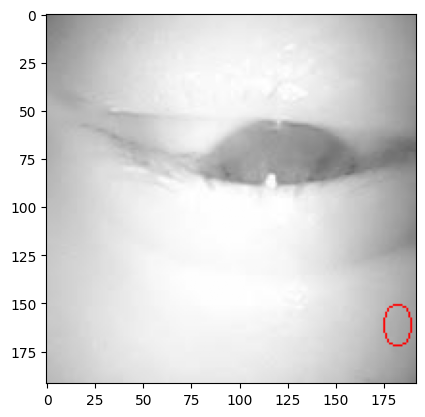

In [16]:
visualize_model(model, num_images=1000, class_to_show=0)

In [17]:
# TODO model do detekcji źrenicy